In [6]:
# Install reqired Dependencies first and run 
import json
import requests
import torch
import tensorflow
import os
import random
import numpy as np
from torchvision import models, transforms  
from PIL import Image, ImageDraw  
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F

In [7]:
# Function to load an image
def load_image(image_path, device):
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # ResNet-50 expects 224x224 images
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
    ])
    return transform(img).unsqueeze(0).to(device)  



In [8]:
# Function for adversial patch
def generate_adversarial_patch(target_class, model, device, iterations=1000, lr=0.1):
    center = (250, 250)
    image_size = (500, 500)
    angles = np.linspace(0, 2 * np.pi, 20, endpoint=False)
    rays = np.random.uniform(20, 150, 40)  # Adjusted ray range
    
   
    texture = torch.rand(3, *image_size, requires_grad=True, device=device)
    optimizer = optim.Adam([texture], lr=lr)

   
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize texture to match ResNet-50 input size
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    for i in range(iterations):
        optimizer.zero_grad()
        
        
        input_tensor = preprocess(texture).unsqueeze(0)  
        
        
        output = model(input_tensor)
        
        
        loss = adversarial_loss(output, target_class)
        (-loss).backward()  
        optimizer.step()

    # Create mask and apply it to the patch
    mask = draw_mask(center, rays, angles, image_size)
    mask_tensor = torch.from_numpy(mask).to(torch.float32).unsqueeze(0).to(device) / 255.0
    patch_array = texture.detach() * mask_tensor
    patch_array = patch_array.permute(1, 2, 0).cpu().numpy()

    return patch_array


In [9]:

def get_class_label(idx):
    return class_idx[str(idx)][1]

def random_classifier(x):
    return torch.rand((1, 3500), requires_grad=True)  

def adversarial_loss(output, target):
    target_score = output[0, target]
    return -target_score

def draw_mask(center, rays, angles, image_size):
    image = Image.new('L', image_size, 0)
    draw = ImageDraw.Draw(image)
    for angle, ray in zip(angles, rays):
        end_x = int(center[0] + ray * np.cos(angle))
        end_y = int(center[1] + ray * np.sin(angle))
        draw.line([center, (end_x, end_y)], fill=255, width=5)  
    return np.array(image)


In [10]:
# Load ImageNet class index
URL = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
class_idx = requests.get(URL).json()

In [11]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet-50 on GPU
model = models.resnet50(pretrained=True)  
model.to(device)  
model.eval()  

#  Comment this if you want to allow user input later
image_path = "/home/faizankhan/code_project/BlindVision/sample.jpg"

#  Uncomment this if you want to allow user input later
# image_path = input("\nEnter your image name or path: ")


input_image = load_image(image_path, device)  

/home/faizankhan/miniconda3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/faizankhan/miniconda3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
target_class = 56  # Example target class (can be changed)

# Function to get class label from class index
def get_class_label(idx):
    return class_idx[str(idx)][1]

patch = generate_adversarial_patch(target_class, model, device, iterations=3500, lr=0.1)


In [13]:

texture = torch.rand(3, 500, 500, requires_grad=True, device=device)  


input_tensor = F.interpolate(texture.unsqueeze(0), size=(224, 224), mode="bilinear", align_corners=False)
input_tensor = (input_tensor - torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)) / \
               torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)  

In [14]:
def load_image(image_path, device):
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # ResNet-50 expects 224x224
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet-50 normalization
    ])
    return transform(img).unsqueeze(0).to(device)  # Add batch dimension & move to GPU/CPU


In [15]:
# Hardcoded image path (since you're using only one image for now)
image_path = "/home/faizankhan/code_project/BlindVision/sample.jpg"

# # Uncomment this if you want to allow user input later
# image_path = input("Enter your image name or path: ")  
# image_path = os.path.join("/home/faizankhan/code_project/BlindVision", image_path)

input_image = load_image(image_path, device)

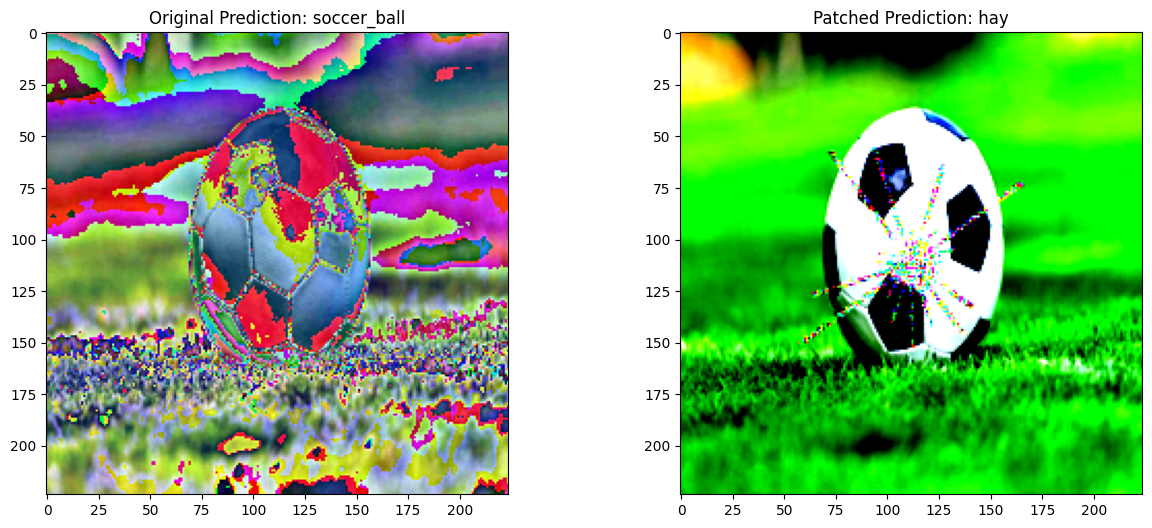

In [17]:
# Predict original image
with torch.no_grad():  
    original_output = model(input_image)
original_class = original_output.argmax().item()
original_label = get_class_label(original_class)

target_class = 56  
patch = generate_adversarial_patch(target_class, model, device, iterations=3500, lr=0.1)  

patch = torch.tensor(patch, dtype=torch.float32, device=device).permute(2, 0, 1)  

resize_transform = transforms.Resize((input_image.shape[2], input_image.shape[3]))  
patch = resize_transform(patch)

patched_image = torch.clamp(input_image + patch, 0, 1)  

# Predict patched image
with torch.no_grad():
    patched_output = model(patched_image)
patched_class = patched_output.argmax().item()
patched_label = get_class_label(patched_class)

save_img = transforms.ToPILImage()(patched_image.squeeze(0))
save_img.save("patched_image.jpg")

# Display results
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].imshow(transforms.ToPILImage()(input_image.squeeze(0)))
ax[0].set_title(f"Original Prediction: {original_label}")
ax[1].imshow(save_img)
ax[1].set_title(f"Patched Prediction: {patched_label}")
plt.show()
